In [1]:
from e3fp.fingerprint.fprint import Fingerprint
from e3fp.fingerprint.db import FingerprintDatabase
from e3fp.fingerprint.metrics.array_metrics import tanimoto
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
logP = pickle.load(open("logp.p", "rb"))

In [3]:
models = [
    ('SVR', SVR(kernel=tanimoto)),
    ('Linear SVR', LinearSVR(max_iter=10000, dual=True)), 
    ('SGD', SGDRegressor()), 
    ('Ridge', Ridge()),
    ('ElasticNet', ElasticNet()),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42))
]
scoring = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']

In [4]:
X_sample, y_sample = resample(logP['fingerprint'], logP['logp'], n_samples=2000, random_state=42)

sample_db = FingerprintDatabase(fp_type=Fingerprint, name="sample")
sample_db.add_fingerprints(X_sample.values)

Null predictor

In [5]:
y_sample.value_counts().head(1)/len(y_sample)

0.8    0.046
Name: logp, dtype: float64

In [6]:
r2_score(logP['logp'], [0.8 for i in range(len(logP))])

-0.02333792302495974

In [7]:
folded_sample_db = sample_db.fold(1024)

results = []
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models:
    result = model_selection.cross_validate(model, sample_db.array, y_sample, cv=kfold, scoring=scoring)
    result['name'] = name
    results.append(result)
    
for name, model in models:
    result = model_selection.cross_validate(model, folded_sample_db.array, y_sample, cv=kfold, scoring=scoring)
    result['name'] = 'folded ' + name
    results.append(result)

model_results = pd.DataFrame(results)

In [8]:
folded_sample_db.get_density()

0.014892578125

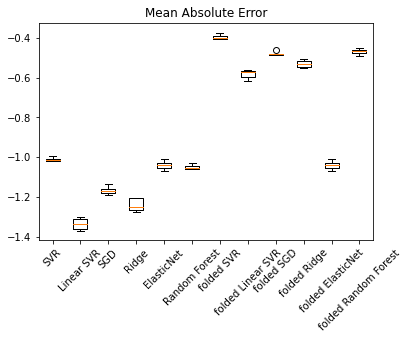

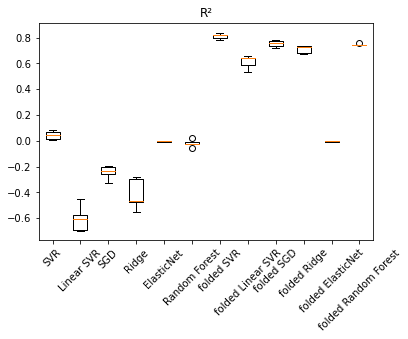

In [10]:
# from itertools import chain
# labels = list(chain.from_iterable((name, name + ' folded') for name, v in models))
pyplot.boxplot(model_results['test_neg_mean_absolute_error'], labels=model_results['name'])
pyplot.title('Mean Absolute Error')
pyplot.xticks(rotation=45)
pyplot.show()

pyplot.boxplot(model_results['test_r2'], labels=model_results['name'])
pyplot.title('R²')
pyplot.xticks(rotation=45)
pyplot.show()

Folding the fingerprints results in some data loss, but higher data density. It appears that these models all function significantly better on more dense data. The highly sparse nature of the fingerprints makes data loss very minimal since the chance of collisions is so low.

Of these, the most promising are SVR with a tanimoto similarity kernel and Random Forest Regression. SGD is also promising and might be explored as it implements a partial fit method which would allow for additional data to be added to improve the model over time.

In [53]:
# db = FingerprintDatabase(fp_type=Fingerprint, name="logp")
# db.add_fingerprints(logP['fingerprint'])

In [54]:
# with open('db.p', mode='wb') as file:
#     pickle.dump(db, file)

Experiment to determine best fold density

In [14]:
fold_bits = [128, 256, 512, 1024]

fold_results = []

fold_results
for bits in fold_bits:
    fdb = pickle.load(open("folded_db.p", "rb")).fold(bits) # using pickled database to avoid mutation errors caused by folding the original
    display('%d: %f' % (bits, fdb.get_density()))
    fold_results.append(model_selection.cross_validate(SVR(kernel=tanimoto), fdb.array, y_sample, cv=kfold, scoring=scoring))

'128: 0.112148'

'256: 0.057555'

'512: 0.029223'

'1024: 0.014893'

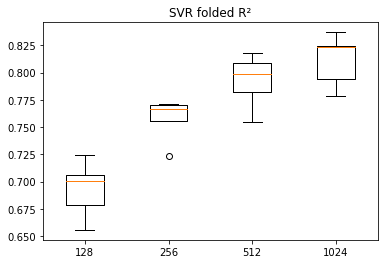

In [15]:
fold_results_df = pd.DataFrame(fold_results)
pyplot.boxplot(fold_results_df.test_r2, labels=[str(bit) for bit in fold_bits])
pyplot.title('SVR folded R²')
pyplot.show()

R² values drop off with each additional fold. Despite the increased data density, accuracy appears to drop. 

In [13]:
folded_sample_db.add_fingerprints(logP['fingerprint'])

In [18]:
folded_sample_db = folded_sample_db.fold(1024)
folded_sample_db.get_density()

0.014987995165982204

In [19]:
# with open('folded_db.p', mode='wb') as file:
#     pickle.dump(folded_sample_db, file)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(logP['fingerprint'], logP['logp'], test_size=0.2, random_state=42)

In [ ]:
clf = SVR(kernel=tanimoto)
clf.fit(folded_sample_db.array, logP.logp)

In [122]:
# fdb = pickle.load(open("folded_db.p", "rb"))
# fdb.get_density()

0.014892578125

In [5]:
logP_df = logP.drop('molecule', axis=1)
logP_df.head()
# with open('logp_df.p', mode='wb') as file:
#     pickle.dump(logP_df, file)

,smiles,logp,fingerprint,rdkit_logp
0,C[C@H]([C@@H](C)Cl)Cl,2.3,"(False, False, False, False, False, False, Fal...",2.2410
1,C(C=CBr)N,0.3,"(False, False, False, False, False, False, Fal...",0.8537
2,CCC(CO)Br,1.3,"(False, False, False, False, False, False, Fal...",1.1522
3,[13CH3][13CH2][13CH2][13CH2][13CH2][13CH2]O,2.0,"(False, False, False, False, False, False, Fal...",1.5590
4,CCCOCCP,0.6,"(False, False, False, False, False, False, Fal...",1.2881


In [6]:
with open('logp_df.p', mode='wb') as file:
    pickle.dump(logP_df, file)